# Equação de Poisson 2D

Vamos resolver numericamente a equação do calor a 2D:

\begin{align*}
\nabla^2 u = f
\end{align*}

# Imports

In [41]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from typing import Callable

# Sistema de Equações Lineares

Vamos usar o método das diferenças finitas seguido de uma vetorização da grelha para transformar a equação diferencial num sistema de equações lineares:

\begin{align*}
A\textbf u = \textbf b
\end{align*}

In [42]:
def poissonDiscrete(uu: np.ndarray, cf: np.ndarray, hx: float, hy: float, ff: np.ndarray, rm: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Discretiza a equação de Poisson a 2D `nabla^2 u = f` numa grelha 2D para condições fronteira de Dirichlet e devolve uma equação da forma Au = b.
        
        :param uu: np.ndarray, estimativa inicial para a solução
        :param cf: np.ndarray, contém True caso o ponto esteja na fronteira
        :param hx: float, distância entre dois pontos xx da grelha
        :param hy: float, distância entre dois pontos yy da grelha
        :param ff: np.ndarray, função f avaliada em todos os pontos da grelha
        :param rm: np.ndarray, usar ordenação row-major em vez de column-major

        :return: tuple containing:
            - np.ndarray, matriz A
            - np.ndarray, vetor u
            - np.ndarray, vetor b
    """

    # Dimensões do problema
    Ny, Nx = uu.shape
    pontos = Nx * Ny

    Fx = 1 / hx**2
    Fy = 1 / hy**2

    # Vetores a criar
    A = np.zeros((pontos, pontos))
    u = np.empty((pontos))
    b = np.empty((pontos))

    # Elementos da diagonal
    A += np.diag(np.array([-2 * (Fx + Fy) for _ in range(pontos)]))


    # Criar vetores row-major
    if rm:
        u = uu.flatten("C")
        b = ff.flatten("C")

        # Matriz de coeficientes
        A += np.diag(np.array([Fy for _ in range(pontos - Nx)]), k=Nx)
        A += np.diag(np.array([Fy for _ in range(pontos - Nx)]), k=-Nx)

        A += np.diag(np.array([Fx for _ in range(pontos - 1)]), k=1)
        A += np.diag(np.array([Fx for _ in range(pontos - 1)]), k=-1)

        # Aplicar condições fronteira
        for i, line in enumerate(cf):
            for j, item in enumerate(line):
                if item:
                    p = i * Nx + j

                    # Colocar apenas um 1 na diagonal
                    A[p, :] = 0
                    A[p, p] = 1

                    # Fixar o valor da fronteira como sendo igual ao valor inicial
                    b[p] = u[p]
    
    # Criar vetores column-major
    else:
        u = uu.flatten("F")
        b = ff.flatten("F")

        # Matriz de coeficientes
        A += np.diag(np.array([Fx for _ in range(pontos - Ny)]), k=Ny)
        A += np.diag(np.array([Fx for _ in range(pontos - Ny)]), k=-Ny)

        A += np.diag(np.array([Fy for _ in range(pontos - 1)]), k=1)
        A += np.diag(np.array([Fy for _ in range(pontos - 1)]), k=-1)

        # Aplicar condições fronteira
        for i, line in enumerate(cf):
            for j, item in enumerate(line):
                if item:
                    p = i + j * Ny

                    # Colocar apenas um 1 na diagonal
                    A[p, :] = 0
                    A[p, p] = 1

                    # Fixar o valor da fronteira como sendo igual ao valor inicial
                    b[p] = u[p]

    return A, u, b

## Método de Jacobi

In [43]:
def jacobi(A: np.ndarray, u: np.ndarray, b: np.ndarray, eps: float = 1e-6, Imax: int = 1_000_000) -> np.ndarray:
    """
        Resolve a equação `Au = b` de forma aproximada usando o método de Jacobi.

        :param A: np.ndarray, matriz de coeficientes
        :param u: np.ndarray, vetor com a estimativa inicial da solução
        :param b: np.ndarray, vetor com o lado direito de cada equação
        :param eps: float, erro desejado (tamanho máximo do último passo)
        :param Imax: int, número máximo de passos

        :return: np.ndarray, vetor solução
    """

    # Retirar a diagonal
    D = np.diag(A)
    LU = A - np.diag(D)

    # Inverter a matriz D (corresponde a inverter cada uma das suas entradas)
    # Passamos também para um array porque a multiplicação matricial por uma matriz diagonal corresponde ao produto interno
    D = D**(-1)

    # Inicializar o loop
    its = 0
    erro = eps + 1
    unow = np.copy(u)
    unext = np.empty_like(unow)

    while erro > eps:
        # Dar o passo
        unext = D * (b - LU @ unow)

        # Calcular o erro
        erro = np.sqrt(np.sum((unext - unow)**2))

        its += 1
        if its > Imax:
            raise ValueError("Número máximo de iterações excedido")

        # Atualizar o array
        unow = np.copy(unext)
    
    return unow


def poisson2Djacslow(uu: np.ndarray, cf: np.ndarray, hx: float, hy: float, ff: np.ndarray, rm: bool = False, eps: float = 1e-6, Imax: int = 1_000_000) -> np.ndarray:
    """
        Resolve a equação de Poisson a 2D `nabla^2 u = f` numa grelha 2D para condições fronteira de Dirichlet usando o método de Jacobi.

        :param uu: np.ndarray, estimativa inicial para a solução
        :param cf: np.ndarray, contém True caso o ponto esteja na fronteira
        :param hx: float, distância entre dois pontos xx da grelha
        :param hy: float, distância entre dois pontos yy da grelha
        :param ff: np.ndarray, função f avaliada em todos os pontos da grelha
        :param rm: np.ndarray, usar ordenação row-major em vez de column-major
        :param eps: float, erro desejado (tamanho máximo do último passo)
        :param Imax: int, número máximo de passos

        :return: np.ndarray, vetor solução
    """

    # Dimensões do problema
    Ny, Nx = uu.shape

    # Discretizar a equação
    A, u, b = poissonDiscrete(uu, cf, hx, hy, ff, rm)

    # Resolver a equação
    sol = jacobi(A, u, b, eps, Imax)

    # Desfazer a ordenação
    if rm:
        sol = np.reshape(sol, (Ny, Nx), "C")
    else:
        sol = np.reshape(sol, (Ny, Nx), "F")

    return sol


def poisson2Djacfast(uu: np.ndarray, cf: np.ndarray, hx: float, hy: float, ff: np.ndarray, eps: float=1e-6, Imax: int = 1_000_000) -> np.ndarray:
    """
        Resolve a equação de Poisson a 2D `nabla^2 u = f` numa grelha 2D quadrada para condições fronteira de Dirichlet usando o método de Jacobi.

        :param uu: np.ndarray, estimativa inicial para a solução
        :param cf: np.ndarray, contém True caso o ponto esteja na fronteira
        :param hx: float, distância entre dois pontos xx da grelha
        :param hy: float, distância entre dois pontos yy da grelha
        :param ff: np.ndarray, função f avaliada em todos os pontos da grelha
        :param eps: float, erro desejado (tamanho máximo do último passo)
        :param Imax: int, número máximo de passos

        :return: np.ndarray, matriz solução
    """

    # Inverter o array das condições fronteira
    mask = 1 - cf

    # Pré-calcular alguns números
    hx2 = hx**2
    hy2 = hy**2

    Fx = hx2 / (2 * (hx2 + hy2))
    Fy = hy2 / (2 * (hx2 + hy2))
    Ff = (hx2 * hy2) / (2 * (hx2 + hy2))

    ff = np.copy(ff) * Ff

    # Inicializar o loop
    its = 0
    erro = eps + 1
    unow = np.copy(uu)
    unext = np.copy(uu)
    while erro > eps:
        # Dar o passo
        unext[1:-1, 1:-1] = unow[1:-1, 1:-1] + mask[1:-1, 1:-1] * (Fy * (unow[1:-1, 2:] + unow[1:-1, :-2]) + Fx * (unow[2:, 1:-1] + unow[:-2, 1:-1]) - ff[1:-1, 1:-1] - unow[1:-1, 1:-1])
        
        # Calcular o erro
        erro = np.sqrt(np.sum((unext - unow)**2))

        its += 1
        if its > Imax:
            raise ValueError("Número máximo de iterações excedido")

        # Atualizar o array
        unow = np.copy(unext)
    
    return unow

## Método de SOR

In [223]:
from scipy import fft


def poisson2Dsor(uu: np.ndarray, cf: np.ndarray, hx: float, hy: float, ff: np.ndarray, eps: float=1e-6, Imax: int = 1_000_000, omega: float = 0.9) -> np.ndarray:
    """
        Resolve a equação de Poisson a 2D `nabla^2 u = f` numa grelha 2D quadrada para condições fronteira de Dirichlet usando o método de Gauss-Seidel.

        :param uu: np.ndarray, estimativa inicial para a solução
        :param cf: np.ndarray, contém True caso o ponto esteja na fronteira
        :param hx: float, distância entre dois pontos xx da grelha
        :param hy: float, distância entre dois pontos yy da grelha
        :param ff: np.ndarray, função f avaliada em todos os pontos da grelha
        :param eps: float, erro desejado (tamanho máximo do último passo)
        :param Imax: int, número máximo de passos
        :param omega: float, fator de relaxação

        :return: np.ndarray, matriz solução
    """
    # Dimensões do problema
    Ny, Nx = uu.shape

    # Inverter o array das condições fronteira
    mask = np.array(1 - cf, dtype=bool)

    # Pré-calcular alguns números
    hx2 = hx**2
    hy2 = hy**2

    Fx = hx2 / (2 * (hx2 + hy2))
    Fy = hy2 / (2 * (hx2 + hy2))
    Ff = (hx2 * hy2) / (2 * (hx2 + hy2))

    ff = np.copy(ff) * Ff

    # Evitar erro caso Nx seja par (se Nx for par não podemos usar ::2 abaixo para selecionar só red/ black)
    even = Nx % 2 == 0
    if even:
        uuTemp = np.zeros((Ny, Nx+1))
        uuTemp[:, :-1] = uu
        
        maskTemp = np.zeros((Ny, Nx+1))
        maskTemp[:, :-1] = mask

        ffTemp = np.zeros((Ny, Nx+1))
        ffTemp[:, :-1] = ff

        uu = uuTemp
        mask = maskTemp
        ff = ffTemp

        Nx += 1

    
    # Usar ordenação row-major
    mask = mask.flatten("C")
    ff = ff.flatten("C")
    unow = uu.flatten("C")
    unext = uu.flatten("C")

    # Inicializar o loop
    its = 0
    erro = eps + 1
    while erro > eps:
        # Passo red seguido de black
        for color in [0, 1]:
            uNovo = Fy * (unext[Nx+1+color:-Nx+1:2] + unext[Nx-1+color:-Nx-1:2]) + Fx * (unext[2*Nx+color::2] + unext[+color:-2 * Nx:2]) - ff[Nx+color:-Nx:2]
            unext[Nx+color:-Nx:2] += mask[Nx+color:-Nx:2] * omega * (uNovo - unext[Nx+color:-Nx:2]) 
         
        # Calcular o erro
        erro = np.sqrt(np.sum((unext - unow)**2))

        its += 1
        if its > Imax:
            raise ValueError("Número máximo de iterações excedido")

        # Atualizar o array
        unow = np.copy(unext)
    
    if even:
        sol = np.reshape(unow, (Ny, Nx), "C")[:, :-1]
    else:
        sol = np.reshape(unow, (Ny, Nx), "C")
    return sol


# Passo normal
# for i in range(Ny):
#     for j in range(Nx):
#         if not cf[i, j]:
#             uDelta = Fx * (unext[i+1, j] + unext[i-1, j]) + Fy * (unext[i, j + 1] + unext[i, j - 1]) - ff[i, j] - unext[i, j]

#             unext[i, j] += omega * uDelta

# Testar

Vamos agora fazer alguns testes.

## Testar os Método de Resolução de Sistemas Lineares

In [45]:
# Função que compara o resultado de um método numérico de resolução de sistemas de equações lineares com os valores determinados pelo numpy
def testelinear(metodo: Callable, n: int, eps: float = 1e-5, Imax: int = 1_000_000) -> None:
    """
        Testa o método de resolução de sistemas de `n` equações lineares `método(Ao, bbo)` contra os valores encontrados pelo numpy para vários sistemas!
    """

    # Um sistema de `n` equações lineares aleatórias.

    # Gerar o sistema
    Ao = np.random.rand(n, n)
    bbo = np.random.rand(n)
    uuo = np.random.rand(n)

    # Certificar que o sistema é diagonal dominante
    for i in range(n):
        Ao[i, i] += 3

    # Meu método
    xx = metodo(Ao, uuo, bbo, eps, Imax)

    # Numpy
    nn = np.linalg.solve(Ao, bbo)

    # Comparar
    dif = np.max(abs(xx - nn))

    print(f"Para um sistema aleatório este método difere do resultado do numpy no máximo {dif:.3e}.\n")

    return


print("MÉTODO DE JACOBI")
for _ in range(5):
    testelinear(jacobi, 5)

MÉTODO DE JACOBI
Para um sistema aleatório este método difere do resultado do numpy no máximo 1.359e-06.

Para um sistema aleatório este método difere do resultado do numpy no máximo 8.034e-07.

Para um sistema aleatório este método difere do resultado do numpy no máximo 1.907e-06.

Para um sistema aleatório este método difere do resultado do numpy no máximo 1.874e-06.

Para um sistema aleatório este método difere do resultado do numpy no máximo 1.834e-06.



## Caso 1

Vamos considerar a função:

$$
u(x, y) = \sin\left(2\pi \frac{x}{L_x}\right)\sin\left(2\pi \frac{y}{L_y}\right)
$$

Temos que:
$$
\nabla^2u(x, y) = -\left[\left(\frac{2\pi}{L_x}\right)^2 + \left(\frac{2\pi}{L_y}\right)^2\right]u(x, y)
$$

Vamos resolver esta última equação, e ver se a solução é a nossa função $u$ inicial!

In [217]:
# Constantes
Lx = 1
Ly = 1

# Parâmetros
Nx = 151
Ny = 151

hx = Lx / (Nx - 1)
hy = Ly / (Ny - 1)

uu = np.zeros((Ny, Nx))
cf = np.full((Ny, Nx), False)

# Condições do problema (a fronteira é só a borda da caixa)
for i in range(Ny):
    for j in range(Nx):
        if i in [0, Ny-1] or j in [0, Nx-1]:
            cf[i, j] = True


k = 2

def u(x, y):
    return np.sin(k * np.pi * x / Lx) * np.sin(k * np.pi * y / Ly)


def f(x, y):
    return - 1 * (((k * np.pi) / Lx)**2 + ((k * np.pi) / Ly)**2) * u(x, y)


xx = np.linspace(0, Lx, Nx)
yy = np.linspace(0, Ly, Ny)

mx, my = np.meshgrid(xx, yy)

ss = u(mx, my)
ff = f(mx, my)

### Método de Jacobi Rápido

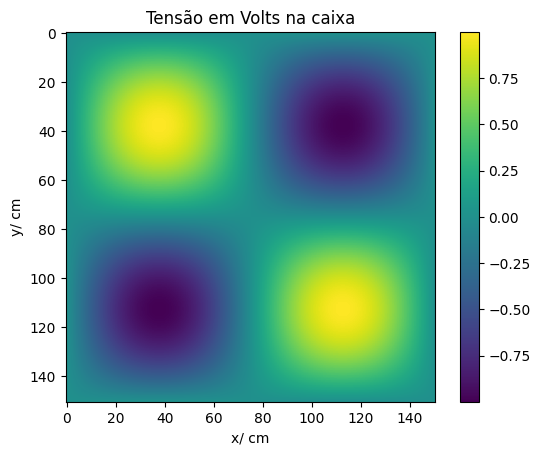

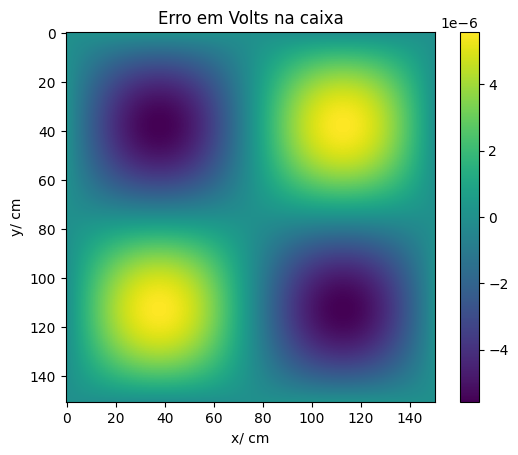

In [218]:
sol = poisson2Djacfast(uu, cf, hx, hy, ff, eps=1e-5)

# Mostrar a solução
plt.imshow(sol)
plt.colorbar()
plt.title("Tensão em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

# Comparar com a solução exata
plt.imshow(sol - ss)
plt.colorbar()
plt.title("Erro em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

### Método de Jacobi Lento

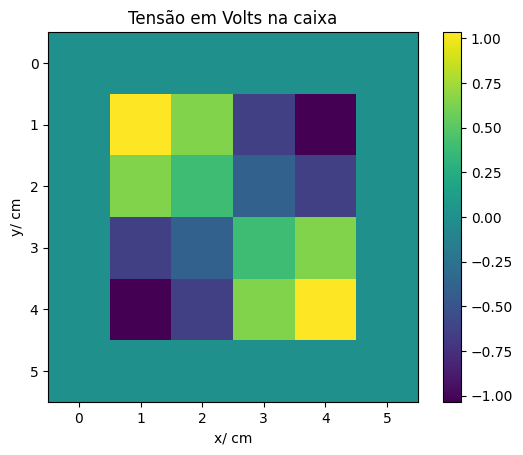

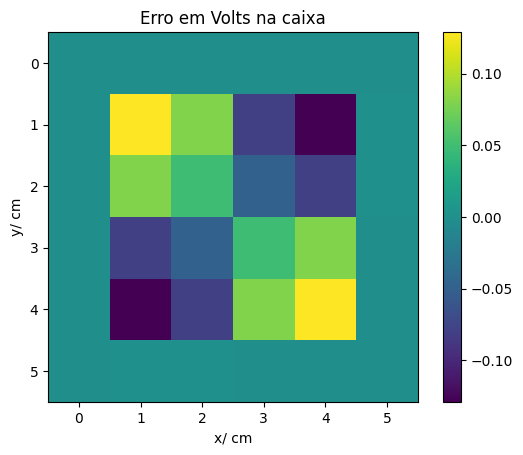

In [213]:
sol = poisson2Djacslow(uu, cf, hx, hy, ff, eps=1e-5, rm=True)

# Mostrar a solução
plt.imshow(sol)
plt.colorbar()
plt.title("Tensão em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

# Comparar com a solução exata
plt.imshow(sol - ss)
plt.colorbar()
plt.title("Erro em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

### Método de Gauss Seidel

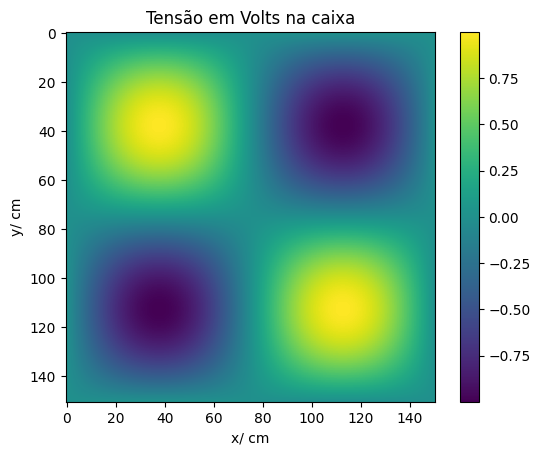

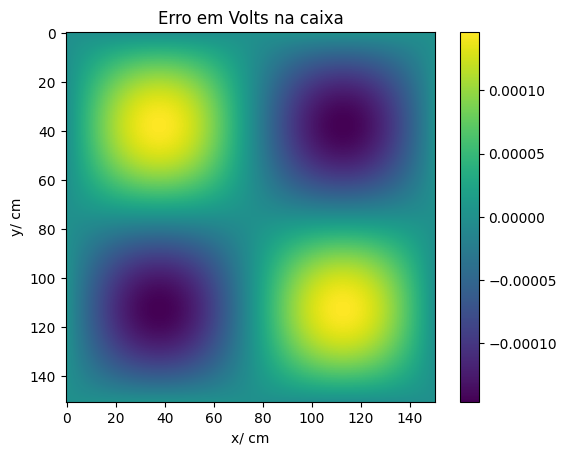

In [224]:
sol = poisson2Dsor(uu, cf, hx, hy, ff, eps=1e-10, omega=1.9)

# Mostrar a solução
plt.imshow(sol)
plt.colorbar()
plt.title("Tensão em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

# Comparar com a solução exata
plt.imshow(sol - ss)
plt.colorbar()
plt.title("Erro em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

## Caso 2

Vamos usar o exemplo 9.2 do livro do Newman.

In [50]:
# Constantes
L = 1

# Parâmetros
N = 100

aa = L / N

uu = np.zeros((N+1, N+1))
fronteira = np.full((N + 1, N + 1), False)
rho = np.zeros((N+1, N+1))

# Condições do problema
for i in range(N + 1):
    for j in range(N + 1):
        # Potencial na borda da caixa é 0 (não resolver nas fronteiras também)
        if i in [0, N] or j in [0, N]:
            fronteira[i, j] = True
        
        # Carga positiva
        elif (20 <= i <= 40 and 60 <= j <= 80):
            rho[i, j] = 1
        
        # Carga negativa
        elif (60 <= i <= 80 and 20 <= j <= 40):
            rho[i, j] = -1

# Usamos epsilon0 = 1
ff = -rho

### Método de Jacobi Rápido

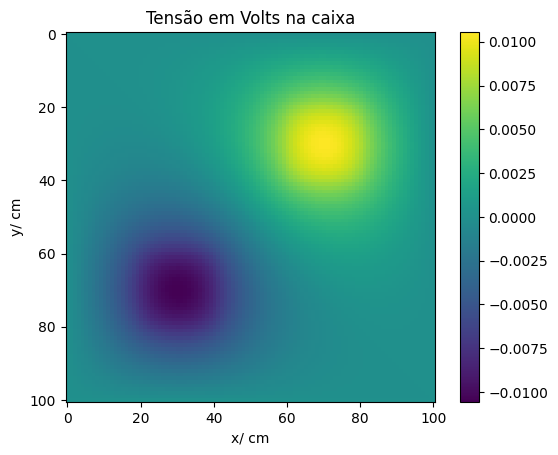

In [51]:
sol = poisson2Djacfast(uu, fronteira, aa, aa, ff, eps=1e-5)

plt.imshow(sol)
plt.colorbar()
plt.title("Tensão em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

### Método de Jacobi Lento

In [52]:
sol = poisson2Djacslow(uu, fronteira, aa, aa, ff, eps=1e-5)

plt.imshow(sol)
plt.colorbar()
plt.title("Tensão em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

KeyboardInterrupt: 

In [ ]:
sol = poisson2Dsor(uu, cf, hx, hy, ff, eps=1e-5, omega=0.95)

# Mostrar a solução
plt.imshow(sol)
plt.colorbar()
plt.title("Tensão em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()

# Comparar com a solução exata
plt.imshow(sol - ss)
plt.colorbar()
plt.title("Erro em Volts na caixa")
plt.xlabel("x/ cm")
plt.ylabel("y/ cm")
plt.show()